## Some Visualizations

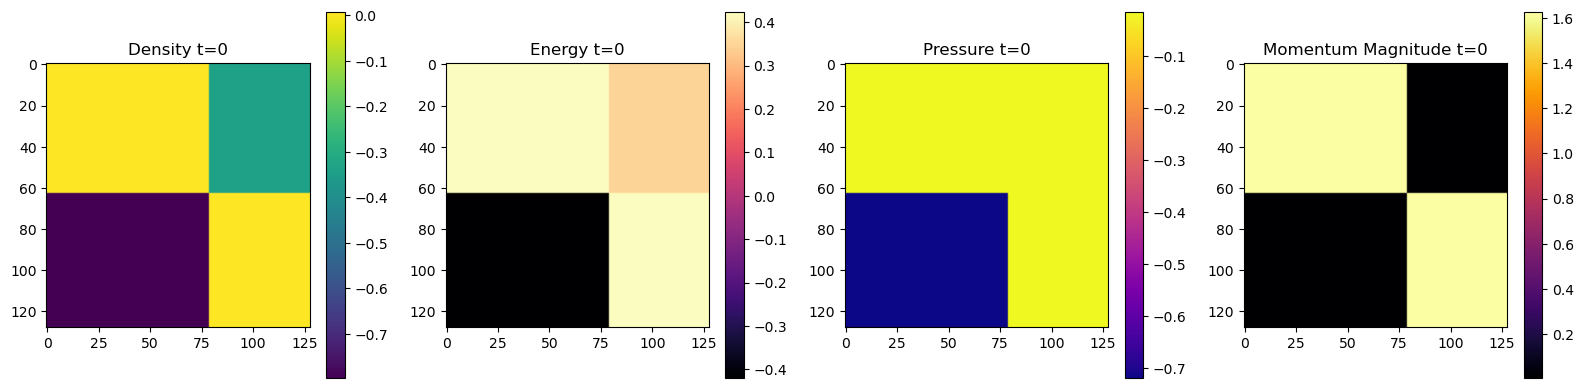

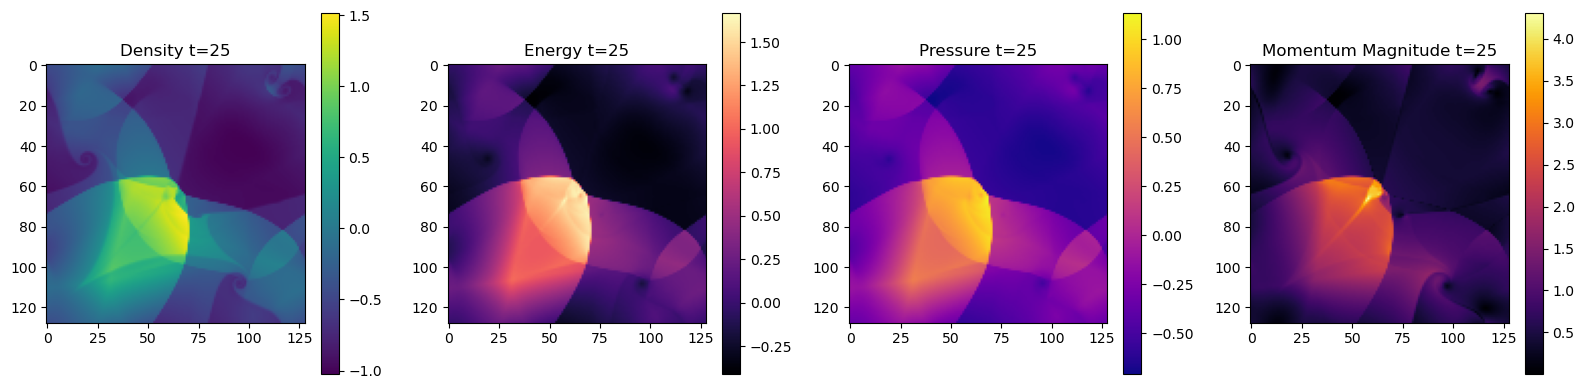

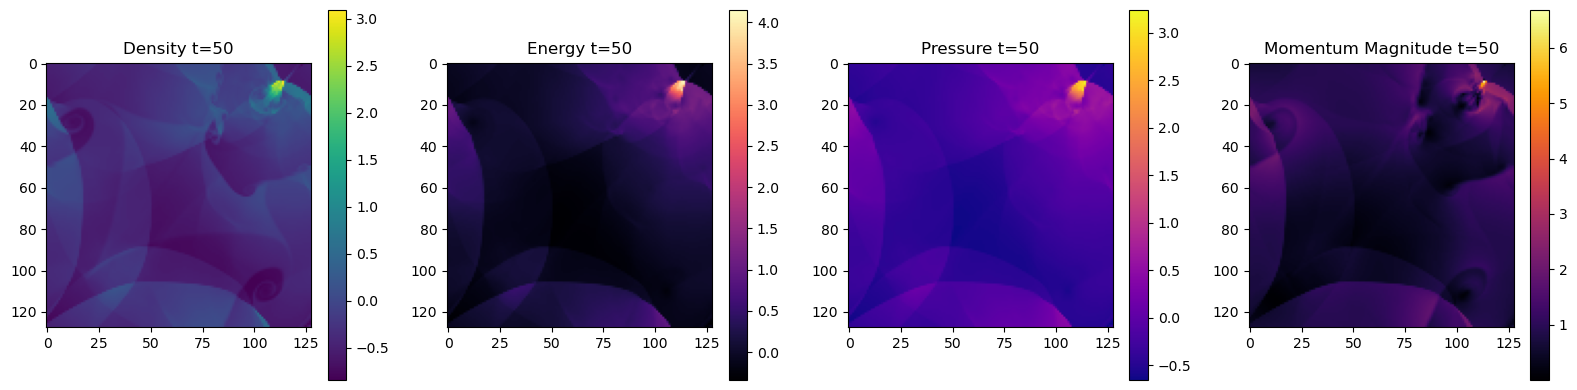

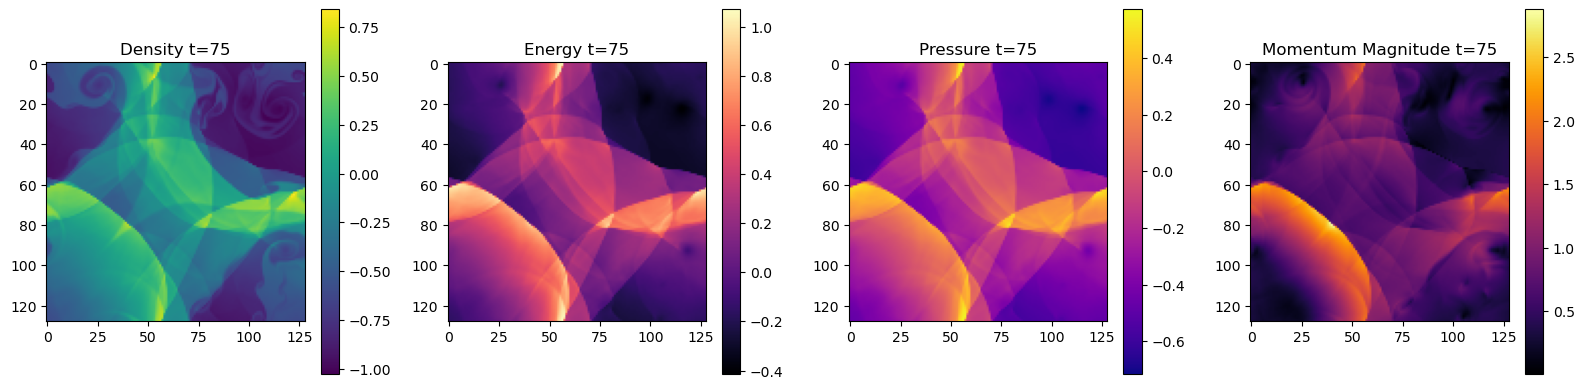

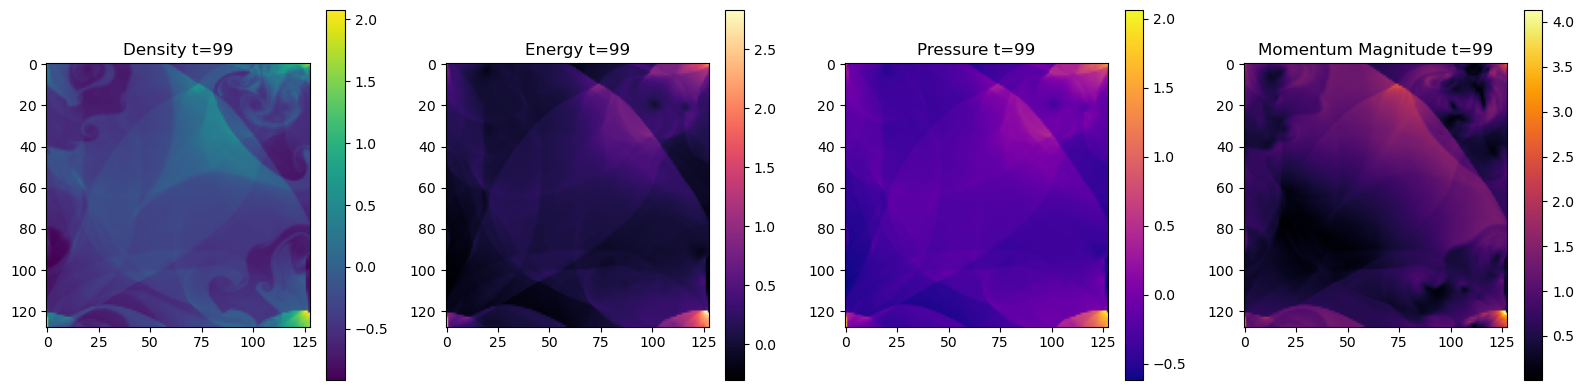

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from euler_coarse import EulerPeriodicDataset

h5_path_train = "/work/imos/datasets/euler_multi_quadrants_periodicBC/data/train/euler_multi_quadrants_periodicBC_gamma_1.22_C2H6_15.hdf5"
stats_path = "/work/imos/datasets/euler_multi_quadrants_periodicBC/stats.yaml"

# instantiate dataset
ds = EulerPeriodicDataset(h5_path_train, stats_path=stats_path, target='absolute', coarsen=(4,4))

sim_idx = 0                   # choose the first simulation
timesteps = [0, 25, 50, 75, 99]  # desired timesteps (0-based indexing)

for t_idx in timesteps:
    # compute flat index: idx = sim_idx * n_per_sim + t_idx
    idx = sim_idx * ds.n_per_sim + t_idx
    data = ds[idx]  # PyG Data object

    # y_density, y_energy, y_pressure, y_momentum are all 1D flattened arrays
    Hc, Wc = ds.Hc, ds.Wc
    density  = data.y_density.reshape(Hc, Wc).cpu().numpy()
    energy   = data.y_energy.reshape(Hc, Wc).cpu().numpy()
    pressure = data.y_pressure.reshape(Hc, Wc).cpu().numpy()
    momentum = data.y_momentum.reshape(Hc, Wc, 2).cpu().numpy()
    speed = np.linalg.norm(momentum, axis=-1)

    # plot 2x2 grid
    fig, axes = plt.subplots(1, 4, figsize=(16,4))
    im0 = axes[0].imshow(density, cmap="viridis"); axes[0].set_title(f"Density t={t_idx}")
    im1 = axes[1].imshow(energy, cmap="magma"); axes[1].set_title(f"Energy t={t_idx}")
    im2 = axes[2].imshow(pressure, cmap="plasma"); axes[2].set_title(f"Pressure t={t_idx}")
    im3 = axes[3].imshow(speed, cmap="inferno"); axes[3].set_title(f"Momentum Magnitude t={t_idx}")

    # add colorbars
    for ax, im in zip(axes, [im0, im1, im2, im3]):
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()


using full-grid samples (512x512), this is large (262144 nodes). Consider coarsening.


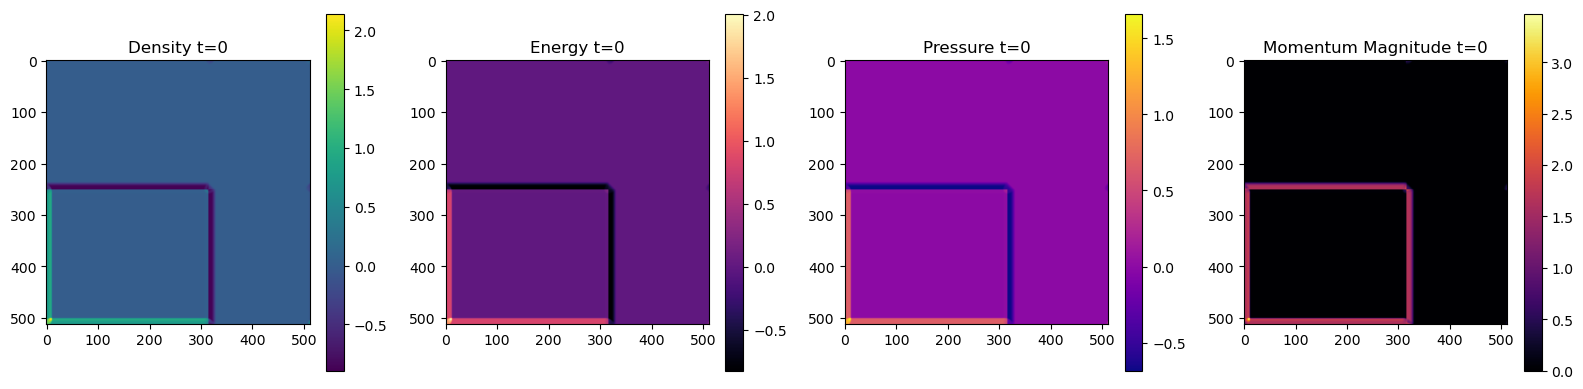

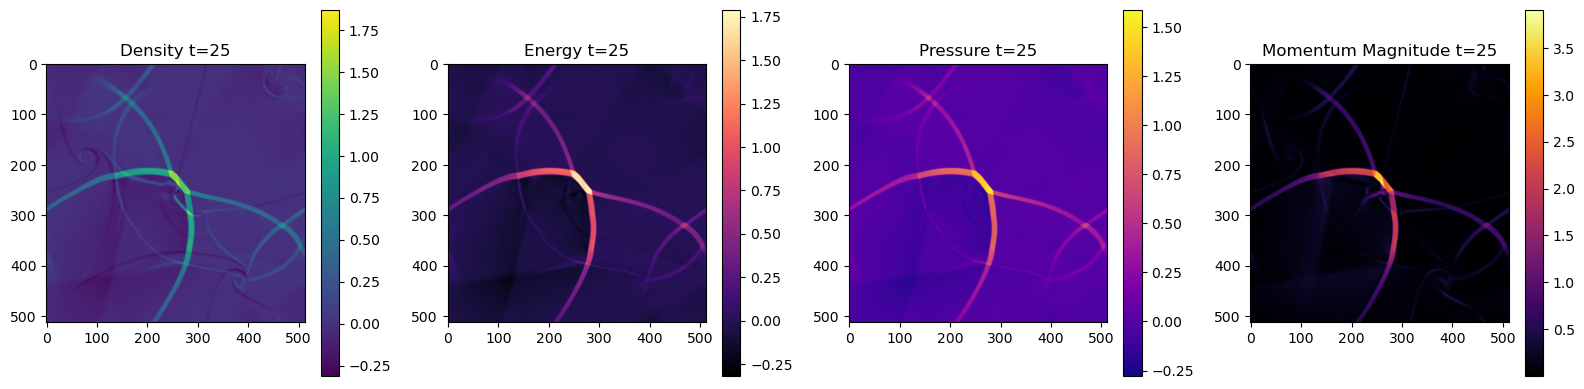

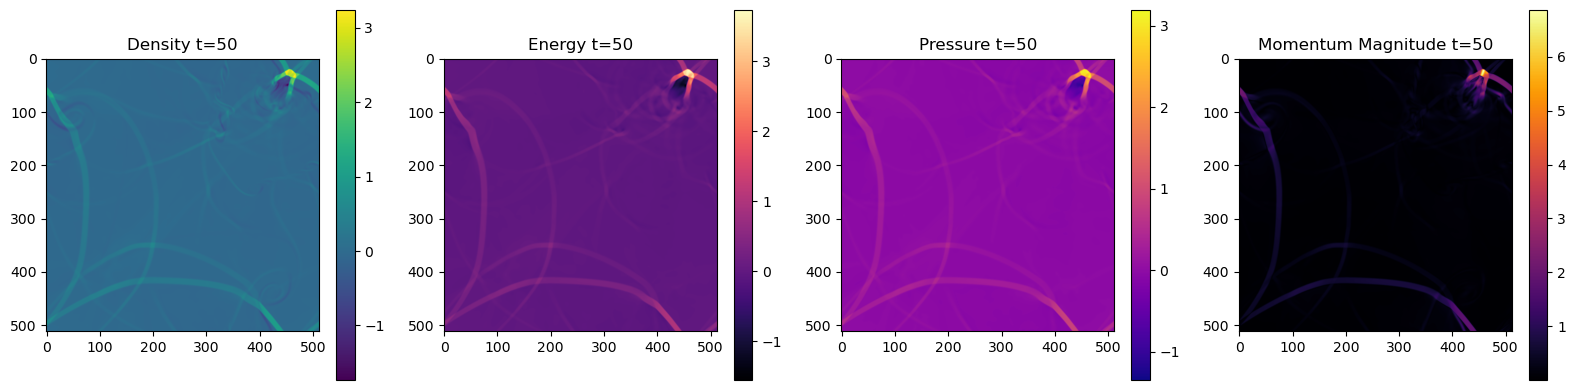

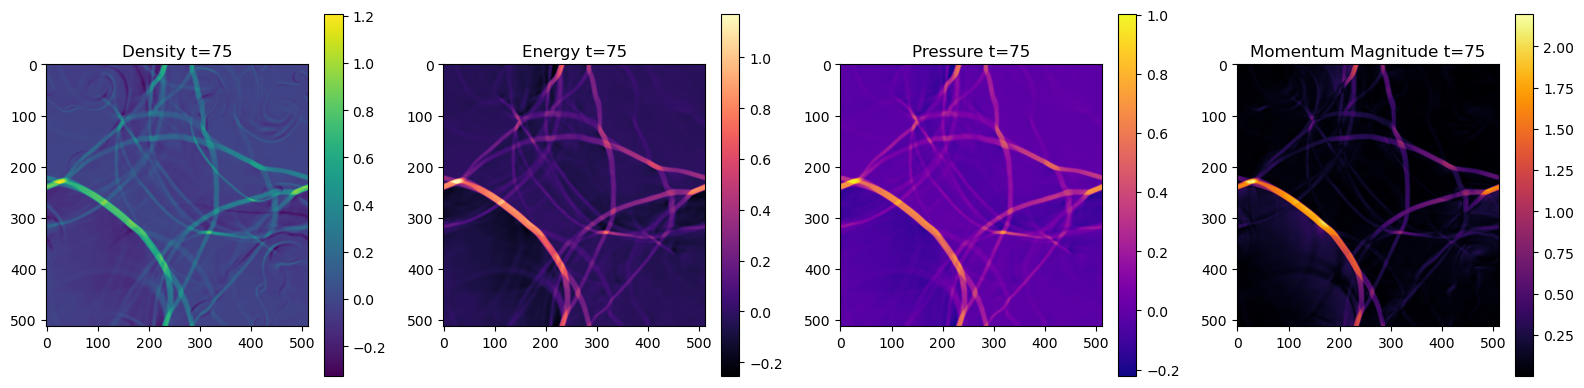

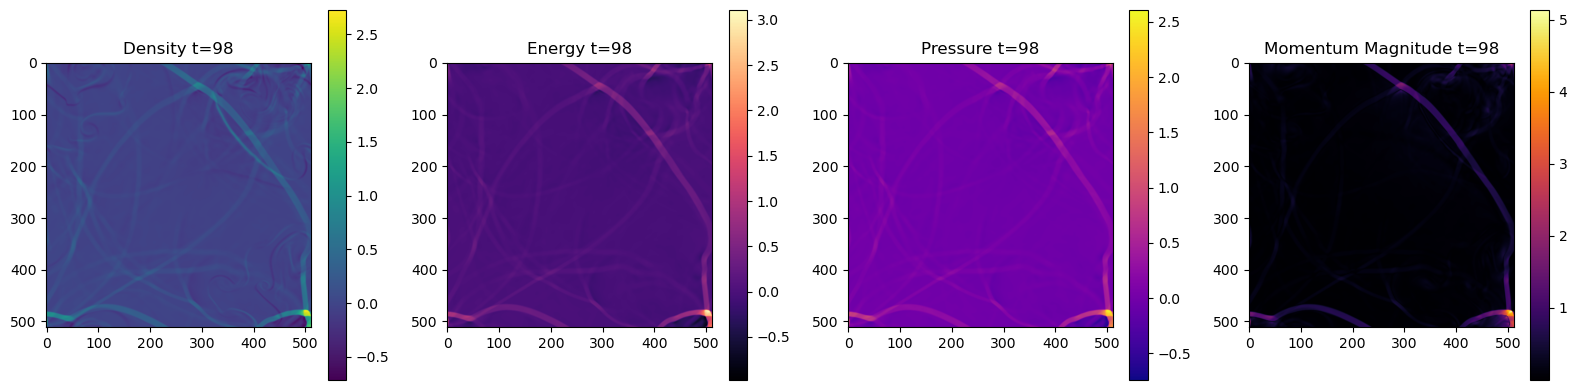

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from euler_coarse import EulerPeriodicDataset

h5_path_train = "/work/imos/datasets/euler_multi_quadrants_periodicBC/data/train/euler_multi_quadrants_periodicBC_gamma_1.22_C2H6_15.hdf5"
stats_path = "/work/imos/datasets/euler_multi_quadrants_periodicBC/stats.yaml"

# instantiate dataset
ds = EulerPeriodicDataset(h5_path_train, stats_path=stats_path, time_window=2, target='delta')

sim_idx = 0                   # choose the first simulation
timesteps = [0, 25, 50, 75, 98]  # desired timesteps (0-based indexing)

for t_idx in timesteps:
    # compute flat index: idx = sim_idx * n_per_sim + t_idx
    idx = sim_idx * ds.n_per_sim + t_idx
    data = ds[idx]  # PyG Data object

    # y_density, y_energy, y_pressure, y_momentum are all 1D flattened arrays
    Hc, Wc = ds.Hc, ds.Wc
    density  = data.y_density.reshape(Hc, Wc).cpu().numpy()
    energy   = data.y_energy.reshape(Hc, Wc).cpu().numpy()
    pressure = data.y_pressure.reshape(Hc, Wc).cpu().numpy()
    momentum = data.y_momentum.reshape(Hc, Wc, 2).cpu().numpy()
    speed = np.linalg.norm(momentum, axis=-1)

    # plot 2x2 grid
    fig, axes = plt.subplots(1, 4, figsize=(16,4))
    im0 = axes[0].imshow(density, cmap="viridis"); axes[0].set_title(f"Density t={t_idx}")
    im1 = axes[1].imshow(energy, cmap="magma"); axes[1].set_title(f"Energy t={t_idx}")
    im2 = axes[2].imshow(pressure, cmap="plasma"); axes[2].set_title(f"Pressure t={t_idx}")
    im3 = axes[3].imshow(speed, cmap="inferno"); axes[3].set_title(f"Momentum Magnitude t={t_idx}")

    # add colorbars
    for ax, im in zip(axes, [im0, im1, im2, im3]):
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

## Coarse Dataset Tests

In [ ]:
import time
import numpy as np
from torch_geometric.loader import DataLoader
from euler_coarse import EulerPeriodicDataset

h5_path = "/work/imos/datasets/euler_multi_quadrants_periodicBC/data/train/euler_multi_quadrants_periodicBC_gamma_1.76_Ar_-180.hdf5"
stats_path = "/work/imos/datasets/euler_multi_quadrants_periodicBC/stats.yaml"

### 1) Full-grid dataset checks

In [ ]:
print("=== Full-grid dataset (coarsen=(1,1)) ===")
ds_full = EulerPeriodicDataset(h5_path, stats_path=stats_path, time_window=1, normalize=True, coarsen=(1,1))
print("Dataset created:", len(ds_full))

# basic metadata checks
print("len(dataset) =", len(ds_full))
print("n_sims, n_t, H, W =", ds_full.n_sims, ds_full.n_t, ds_full.H, ds_full.W)
print("n_per_sim =", ds_full.n_per_sim, "total_samples =", ds_full.total_samples)

# static cache checks
print("static cache keys:", sorted(list(ds_full._static_cache.keys())))
print("x_periodic, y_periodic:", ds_full._static_cache.get("x_periodic"), ds_full._static_cache.get("y_periodic"))
print("gamma:", ds_full._static_cache.get("gamma"))
print("pos_template shape:", ds_full._static_cache.get("pos_template").shape)

# fast I/O test: load arrays only (no edge build)
arrs = ds_full._load_time_window(sim_idx=0, t_idx=0)
print("density shape (full):", arrs["density"].shape)   # expect (time_window, H, W)
print("momentum shape (full):", arrs["momentum"].shape) # expect (time_window, H, W, 2)

# build the full-grid graph for a single sample (this may be heavy)
t0 = time.time()
data_full = ds_full[0]
t1 = time.time()
print("\nBuilt full Data object in {:.2f}s".format(t1-t0))
print("data_full.x shape (N, C):", data_full.x.shape)
print("data_full.pos shape:", data_full.pos.shape)
print("data_full.edge_index shape:", data_full.edge_index.shape)
print("data_full.edge_attr shape:", data_full.edge_attr.shape)
print("global features u:", data_full.u)

# simple assert to ensure original behaviour returns full-grid-size nodes
N_full = ds_full.H * ds_full.W
assert data_full.x.shape[0] == N_full, f"Full-grid Data node count mismatch: {data_full.x.shape[0]} != {N_full}"

### 2) Coarse dataset checks

In [ ]:
print("\n=== Coarsened dataset (example coarsen=(2,2)) ===")
sh, sw = 2, 2
ds_coarse = EulerPeriodicDataset(h5_path, stats_path=stats_path, time_window=1, normalize=True, coarsen=(sh,sw))
print("Dataset created:", len(ds_coarse))
print("original H,W:", ds_coarse.H, ds_coarse.W, "-> coarsened Hc,Wc:", ds_coarse.Hc, ds_coarse.Wc)

# cache keys
print("static cache keys (coarse):", sorted(list(ds_coarse._static_cache.keys())))
assert "pos_template_coarse" in ds_coarse._static_cache, "pos_template_coarse missing from cache"
assert "x_coords_coarse" in ds_coarse._static_cache, "x_coords_coarse missing from cache"

# quick check _load_time_window returns coarsened shapes
arrs_c = ds_coarse._load_time_window(sim_idx=0, t_idx=0)
print("density shape (coarse):", arrs_c["density"].shape)   # expect (time_window, Hc, Wc)
print("momentum shape (coarse):", arrs_c["momentum"].shape) # expect (time_window, Hc, Wc, 2)
assert arrs_c["density"].shape[1:] == (ds_coarse.Hc, ds_coarse.Wc), "density coarsened shape mismatch"
assert arrs_c["momentum"].shape[1:] == (ds_coarse.Hc, ds_coarse.Wc, 2), "momentum coarsened shape mismatch"

# build the coarsened graph for a single sample
t0 = time.time()
data_c = ds_coarse[0]
t1 = time.time()
print("\nBuilt coarsened Data object in {:.2f}s".format(t1-t0))
print("data_c.x shape (N, C):", data_c.x.shape)
print("data_c.pos shape:", data_c.pos.shape)
print("data_c.edge_index shape:", data_c.edge_index.shape)
print("data_c.edge_attr shape:", data_c.edge_attr.shape)
print("global features u:", data_c.u)

# ensure that repeated calls to _build_full_grid_edges use cached tensors
edge_index_2, edge_attr_2 = ds_coarse._build_full_grid_edges()
assert edge_index_2.data_ptr() == data_c.edge_index.data_ptr(), "edge_index not using cached tensor"
assert edge_attr_2.data_ptr() == data_c.edge_attr.data_ptr(), "edge_attr not using cached tensor"
# Quick cache check for pos_template_coarse
pos_cached = ds_coarse._static_cache["pos_template_coarse"]
assert isinstance(pos_cached, np.ndarray), "pos_template_coarse missing or wrong type"
assert pos_cached.shape[0] == data_c.pos.shape[0], "pos_template_coarse node count mismatch"
print("Cache verified for pos_template_coarse (shape and presence).")

# asserts on node count and edge count sanity check
Nc = ds_coarse.Hc * ds_coarse.Wc
assert data_c.x.shape[0] == Nc, f"Coarse Data node count mismatch: {data_c.x.shape[0]} != {Nc}"
# for 4-neighbour directed edges we expect 4*Nc edges (periodic or not)
expected_edges = 4 * Nc
actual_edges = data_c.edge_index.shape[1]
assert actual_edges == expected_edges, f"Expected {expected_edges} edges (4*N), got {actual_edges}"

In [ ]:
print("=== Dataloader test ===")

# create coarse dataset (adjust time_window or stride if needed)
ds_test = EulerPeriodicDataset(h5_path, stats_path=stats_path, time_window=1, normalize=True, coarsen=(sh,sw))

# create DataLoader
loader = DataLoader(ds_test, batch_size=2, shuffle=True)

# iterate over a few batches
for batch_idx, batch in enumerate(loader):
    print(f"\nBatch {batch_idx}:")
    print("Batch x shape:", batch.x.shape)
    print("Batch edge_index shape:", batch.edge_index.shape)
    print("Batch edge_attr shape:", batch.edge_attr.shape)
    print("Batch pos shape:", batch.pos.shape)
    print("Batch global features u:", batch.u)

    if batch_idx >= 2:  # only check first 3 batches
        break

print("Dataloader test passed.")

## Patched Dataset Tests

In [ ]:
import time
import numpy as np
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from euler_patched import EulerPeriodicDataset

h5_path = "/work/imos/datasets/euler_multi_quadrants_periodicBC/data/train/euler_multi_quadrants_periodicBC_gamma_1.76_Ar_-180.hdf5"
stats_path = "/work/imos/datasets/euler_multi_quadrants_periodicBC/stats.yaml"

### 1) Full-grid dataset checks

In [ ]:
print("=== Full-grid dataset (patch_size=None) ===")
ds_full = EulerPeriodicDataset(h5_path, stats_path=stats_path, time_window=1, patch_size=None, normalize=True)
print("Dataset created:", len(ds_full))

# basic metadata checks
print("len(dataset) =", len(ds_full))
print("n_sims, n_t, H, W =", ds_full.n_sims, ds_full.n_t, ds_full.H, ds_full.W)
print("n_per_sim =", ds_full.n_per_sim, "total_samples =", ds_full.total_samples)

# static cache checks
print("static cache keys:", list(ds_full._static_cache.keys()))
print("x_periodic, y_periodic:", ds_full._static_cache.get("x_periodic"), ds_full._static_cache.get("y_periodic"))
print("gamma:", ds_full._static_cache.get("gamma"))
print("pos_template shape:", ds_full._static_cache.get("pos_template").shape)

# fast I/O test: load arrays only (no edge build)
arrs = ds_full._load_time_window(sim_idx=0, t_idx=0)
print("density shape:", arrs["density"].shape)   # expect (time_window, H, W)
print("momentum shape:", arrs["momentum"].shape) # expect (time_window, H, W, 2)

# build the graph for a single sample (this triggers edge construction, may take a few seconds and memory)
t0 = time.time()
data = ds_full[0]   # full-grid graph
t1 = time.time()
print("\nBuilt Data object in {:.1f}s".format(t1-t0))
print("data.x shape (N, C):", data.x.shape)
print("data.pos shape:", data.pos.shape)
print("edge_index shape:", data.edge_index.shape)
print("edge_attr shape:", data.edge_attr.shape)
print("global features u:", data.u)

# simple assert to ensure original behaviour returns full-grid-size nodes
N_full = ds_full.H * ds_full.W
assert data.x.shape[0] == N_full, "Full-grid Data node count mismatch"

### 2) Patched dataset checks

In [ ]:
print("\n=== Patch-enabled dataset: mapping & decode tests ===")
# choose patch size 64 (cells)
patch_size = (64, 64)
ds_patch = EulerPeriodicDataset(
    h5_path,
    stats_path=stats_path,
    time_window=1,
    patch_size=patch_size,
    patch_stride=32,
    normalize=True,
)

# dataset should have computed patches_per_row/col and patches_per_timestep (patches_per_sim)
print("patch_size:", ds_patch.patch_size)
print("patch_stride (h,w):", ds_patch.patch_stride, ds_patch.patch_stride_h, ds_patch.patch_stride_w)
print("patches_per_row, patches_per_col:", ds_patch.patches_per_row, ds_patch.patches_per_col)
print("patches_per_timestep:", ds_patch.patches_per_timestep)
print("n_sims, n_per_sim:", ds_patch.n_sims, ds_patch.n_per_sim)

# expected counts
expected_patches_per_row = (ds_patch.W - patch_size[1]) // ds_patch.patch_stride_w + 1
expected_patches_per_col = (ds_patch.H - patch_size[0]) // ds_patch.patch_stride_h + 1
expected_patches_per_timestep = expected_patches_per_row * expected_patches_per_col
expected_total_samples = ds_patch.n_sims * ds_patch.n_per_sim * expected_patches_per_timestep

print("expected patches_per_row:", expected_patches_per_row, "col:", expected_patches_per_col)
print("expected patches_per_timestep:", expected_patches_per_timestep)
print("dataset.total_samples:", ds_patch.total_samples, "expected:", expected_total_samples)
print("len(dataset):", len(ds_patch))

# assertions
assert ds_patch.patches_per_row == expected_patches_per_row
assert ds_patch.patches_per_col == expected_patches_per_col
assert ds_patch.patches_per_timestep == expected_patches_per_timestep
assert ds_patch.total_samples == expected_total_samples
assert len(ds_patch) == expected_total_samples

# test _decode_index for several important indices
per_timestep = ds_patch.patches_per_timestep
per_sim = ds_patch.n_per_sim * per_timestep
print("per_timestep (patches per timestep):", per_timestep, "per_sim:", per_sim)

# first index
sim0, t0, i0, j0 = ds_patch._decode_index(0)
print("idx 0 ->", sim0, t0, i0, j0)
assert sim0 == 0 and t0 == 0

# last index in first sim
idx_last_first_sim = per_sim - 1
sim_l, t_l, i_l, j_l = ds_patch._decode_index(idx_last_first_sim)
print(f"idx {idx_last_first_sim} ->", sim_l, t_l, i_l, j_l)
assert sim_l == 0 and (0 <= t_l < ds_patch.n_per_sim)

# first index of second sim
idx_per_sim = per_sim
sim2, t2, i2, j2 = ds_patch._decode_index(idx_per_sim)
print(f"idx {idx_per_sim} ->", sim2, t2, i2, j2)
assert sim2 == 1 and t2 == 0

# last global index
idx_last = ds_patch.total_samples - 1
sim_last, t_last, i_last, j_last = ds_patch._decode_index(idx_last)
print(f"last idx {idx_last} -> sim {sim_last}, t {t_last}, i0 {i_last}, j0 {j_last}")
assert sim_last == ds_patch.n_sims - 1
assert 0 <= t_last < ds_patch.n_per_sim

print("\n✅ Mapping & decode tests passed.\n")

# -------------------------------------------------------------------------
# A) CACHE TESTS
# -------------------------------------------------------------------------
print("=== Cache behaviour test ===")

p_h, p_w = ds_patch.patch_size
x_periodic = int(bool(ds_patch._static_cache.get("x_periodic", False)))
y_periodic = int(bool(ds_patch._static_cache.get("y_periodic", False)))
edge_cache_key = f"edge_patch_{p_h}_{p_w}_{x_periodic}_{y_periodic}"

print("Expected patch cache key:", edge_cache_key)
print("initially in static_cache:", [k for k in ds_patch._static_cache.keys() if 'edge' in k])

# Trigger one patch build (calls cached builder)
t0 = time.time()
data0 = ds_patch[0]
t1 = time.time()
print(f"Built first patch in {t1-t0:.3f}s")

print("after building one patch, cached keys:", [k for k in ds_patch._static_cache.keys() if 'edge' in k])
assert edge_cache_key in ds_patch._static_cache, "edge cache key not found after building a patch"

cached = ds_patch._static_cache[edge_cache_key]
edge_index_cached = cached["edge_index"]
edge_attr_cached = cached["edge_attr"]

# call builder again with same cache key -> should return same objects
edge_index2, edge_attr2 = ds_patch._build_grid_edges(
    p_h, p_w,
    data0.pos.reshape(p_h, p_w, 2),
    x_periodic=bool(x_periodic),
    y_periodic=bool(y_periodic),
    cache_key=edge_cache_key,
)
print("edge_index same object:", edge_index2 is edge_index_cached)
print("edge_attr  same object:", edge_attr2 is edge_attr_cached)
assert edge_index2 is edge_index_cached and edge_attr2 is edge_attr_cached

# rebuild without cache key to confirm difference
t0 = time.time()
edge_index_new, edge_attr_new = ds_patch._build_grid_edges(
    p_h, p_w,
    data0.pos.reshape(p_h, p_w, 2),
    x_periodic=bool(x_periodic),
    y_periodic=bool(y_periodic),
    cache_key=None,
)
t1 = time.time()
print(f"Rebuild (no cache key) took {t1-t0:.3f}s")
print("rebuild returned different edge_index object:", edge_index_new is not edge_index_cached)

print("\n✅ Cache tests passed.\n")

# -------------------------------------------------------------------------
# B) SIMPLE DATALOADER TEST
# -------------------------------------------------------------------------
print("=== DataLoader batching test ===")

num_check = 8
idxs = list(range(min(num_check, len(ds_patch))))
subset = Subset(ds_patch, idxs)

loader = DataLoader(subset, batch_size=2, shuffle=False, num_workers=0)

batch = next(iter(loader))
print("Batch.x shape:", batch.x.shape)
print("Batch.pos shape:", batch.pos.shape)
print("Batch.batch shape:", batch.batch.shape)

expected_nodes = 2 * (p_h * p_w)
assert batch.x.shape[0] == expected_nodes, f"expected {expected_nodes} nodes in batch, saw {batch.x.shape[0]}"

print("\n✅ DataLoader batching test passed.\n")
print("All patch-related tests completed successfully.")


### 3) Mean fields checks

In [ ]:
def compute_mean_fields(ds):
    """
    Computes the mean fields values over the entire dataset (all simulations, all timesteps).
    """
    mean_density = []
    mean_pressure = []
    mean_energy = []
    mean_momentum = []  # magnitude

    for i in range(ds.n_sims):
        # load all time possible steps for simulation i
        arrs = ds._load_time_window(sim_idx=i, t_idx=0)
        mean_density.append(arrs["density"].mean())
        mean_pressure.append(arrs["pressure"].mean())
        mean_energy.append(arrs["energy"].mean())

        # for momentum, compute magnitude first
        arrs["momentum"] = np.sqrt((arrs["momentum"]**2).sum(axis=-1))
        mean_momentum.append(arrs["momentum"].mean())

    # now compute global means
    mean_density = sum(mean_density) / ds.n_sims
    mean_pressure = sum(mean_pressure) / ds.n_sims
    mean_energy = sum(mean_energy) / ds.n_sims
    mean_momentum = sum(mean_momentum) / ds.n_sims

    return mean_density, mean_pressure, mean_energy, mean_momentum

In [ ]:
train_path = "/work/imos/datasets/euler_multi_quadrants_periodicBC/data/train/euler_multi_quadrants_periodicBC_gamma_1.4_Dry_air_20.hdf5"
valid_path = "/work/imos/datasets/euler_multi_quadrants_periodicBC/data/valid/euler_multi_quadrants_periodicBC_gamma_1.4_Dry_air_20.hdf5"
test_path = "/work/imos/datasets/euler_multi_quadrants_periodicBC/data/test/euler_multi_quadrants_periodicBC_gamma_1.4_Dry_air_20.hdf5"

train_ds = EulerPeriodicDataset(train_path, stats_path=stats_path, time_window=1, patch_size=None, normalize=True)
valid_ds = EulerPeriodicDataset(valid_path, stats_path=stats_path, time_window=1, patch_size=None, normalize=True)
test_ds = EulerPeriodicDataset(test_path, stats_path=stats_path, time_window=1, patch_size=None, normalize=True)

# compute mean fields for each split
train_means = compute_mean_fields(train_ds)
valid_means = compute_mean_fields(valid_ds)
test_means = compute_mean_fields(test_ds)

print("Train means (density, pressure, energy, momentum):", train_means)
print("Valid means (density, pressure, energy, momentum):", valid_means)
print("Test means (density, pressure, energy, momentum):", test_means)